# STEP 1: IMPORTING & READING

## Import all needed packages and data files.

In [2]:
# Packages
import pandas as pd                       # Module for working with data frames
import re                                 # Module for working with regular expressions
from datetime import datetime, timedelta  # Module for working with timestamps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

# Data
formData = pd.read_csv('form_data.csv')
taskData = pd.read_csv('task_data.csv')

pd.set_option('display.max_columns', 70)

## Print the first few rows of each dataframe to check whether the data got read correctly.

In [3]:
formData[:3]

,student_id,group,test_task,task_1,task_2,task_3,task_1_duck,task_2_duck,task_3_duck,survey_q1,survey_q2,survey_q3,perception_q1,perception_q2,perception_q3,perception_q4,perception_q5,perception_q6,perception_q7,big_five_q1,big_five_q2,big_five_q3,big_five_q4,big_five_q5,big_five_q6,big_five_q7,big_five_q8,big_five_q9,big_five_q10
0,"""s18""","""task_set_b""",Trial_Task object (91),Trial_Task object (92),Trial_Task object (93),Trial_Task object (94),Trial_Task object (95),Trial_Task object (96),Trial_Task object (97),"""Rarely""","""Somewhat Agree""","""""","""Somewhat Agree""","""Neutral""","""Somewhat Agree""","""Somewhat Agree""","""Neutral""","""Neutral""","""Somewhat Disagree""","""Somewhat Disagree""","""Somewhat Agree""","""Somewhat Disagree""","""Strongly Agree""","""Neutral""","""Somewhat Agree""","""Strongly Disagree""","""Somewhat Agree""","""Somewhat Disagree""","""Somewhat Agree"""
1,"""s14""","""task_set_a""",Trial_Task object (1),Trial_Task object (2),Trial_Task object (3),Trial_Task object (4),Trial_Task object (5),Trial_Task object (6),Trial_Task object (7),"""Sometimes""","""Neutral""","""""","""Neutral""","""Neutral""","""Neutral""","""Somewhat Agree""","""Neutral""","""Somewhat Agree""","""Somewhat Disagree""","""Somewhat Disagree""","""Somewhat Agree""","""Somewhat Disagree""","""Somewhat Agree""","""Neutral""","""Somewhat Agree""","""Neutral""","""Somewhat Agree""","""Somewhat Disagree""","""Somewhat Agree"""
2,"""Black-Hippopotamus""","""task_set_a""",Trial_Task object (8),Trial_Task object (9),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

taskData[:3]

,id,task_name,student_solution,start_time,end_time,duration,solved_with_duck,perceived_complexity,familiarity,talking,silence
0,11,"""Confused Decoder""","""def confused_decoder(cipher):\n """"""\n ...",2023-11-29 21:49:57.437599+00:00,2023-11-29 21:59:02.759828+00:00,0:09:05.322229,False,"""Somewhat Difficult""","""Somewhat Disagree""",NaN,"""Strongly Agree"""
1,1,"""Manual sum""","""def manual_sum(lst):\n """"""\n INPUT: [1,...",2023-11-29 11:57:15.824662+00:00,2023-11-29 11:58:24.973725+00:00,0:01:09.149063,False,"""Very Easy""","""Strongly Agree""",NaN,NaN
2,12,"""Parentheses Checker""","""def all_parentheses(n):\n """"""\n INPUT: ...",2023-11-29 21:59:17.852453+00:00,2023-11-29 22:07:47.111019+00:00,0:08:29.258566,False,"""Somewhat Difficult""","""Somewhat Disagree""",NaN,"""Strongly Agree"""


This looks good! There are just a few small things to note:

*   Pandas automatically changed empty fields to 'NaN'. This is not an issue.
*   In the form's data, task identifiers are written like 'Trial_Task object (x)'. However, in the tasks' data this is simply an ID 'x'. This will have to be fixed so the two tables can reference each other.
*   There is at least one random ID: 'Black-Hippopotamus'. However, we got no messages of anyone using the randomly generated ID. Since we cannot link this data to the participant it belongs to, it will have to be discarded.
*   The IDs in the form data are written like 'sX'. For simplicity's sake, we will change this.
*   The participant's assigned group in the form data is written like 'task_set_x'. Again, we will change this to something simpler.
*   Similarly, the Likert-style answers are currently string like "somewhat agree". This should be changed to numerical values for easier statistical processing.
*   The tutorial task can be removed from the data, since its only purposed was to familiarize the participants with the format of the tasks.
*   The csv files extracted from our form seem to have a redundant amount of quotation marks around string answers. We will remove these where applicable (i.e. non-qualitative cells).


# STEP 2: TRANSFORMING
## Make the changes discussed at the end of the previous step

The points mentioned at the end of the previous step are all relatively simple data transformations. Let's write some simple helper functions to keep the code as clear as possible, however.

In [5]:
def task_object_to_id(x):
  if str(x) == 'nan': return x
  pattern = r'\d+'  # Regular expression for one or more digits
  result = re.findall(pattern, x)
  result = int(result[0])
  return result

def task_set_to_letter(x):
  if "_a" in x: return 'A'
  elif "_b" in x: return 'B'
  else: return x


def likert_to_int(x):
  quotes = "\"'"
  x = x.strip(quotes)
  if x == "Strongly Disagree" or x == "Very Easy" or x == "Never": return 1
  elif x == "Somewhat Disagree" or x == "Somewhat Easy" or x == "Rarely": return 2
  elif x == "Neutral" or x == "Sometimes": return 3
  elif x == "Somewhat Agree" or x == "Somewhat Difficult" or x == "Frequently": return 4
  elif x == "Strongly Agree" or x == "Stronlgy Agree" or x == "Very Difficult" or x == "Always": return 5
  else: return x

Now we can actually execute the transformations we want using the helper functions above.

In [6]:
# Change task IDs to regular numerical IDs instead of 'Trial_Task object (x)'
for columnIndex in range(2,9):
  for rowIndex in range(len(formData)):
    formData.iloc[rowIndex, columnIndex] = task_object_to_id(formData.iloc[rowIndex, columnIndex])

# Change student IDs to regular integer IDs
randomIds = []
for rowIndex in range(len(formData)):
  try:
    formData.student_id[rowIndex] = task_object_to_id(formData.student_id[rowIndex])
  except:
    randomIds += [rowIndex]

# Change group assignment to a regular letter instead of 'task_set_X'
for rowIndex in range(len(formData)):
  formData.group[rowIndex] = task_set_to_letter(formData.group[rowIndex])

# Change likert scales to integers
for rowIndex in range(len(formData)):
  for columnIndex in [9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]:
    if isinstance(formData.iloc[rowIndex, columnIndex], str):
      formData.iloc[rowIndex, columnIndex] = likert_to_int(formData.iloc[rowIndex, columnIndex])
for rowIndex in range(len(taskData)):
  for columnIndex in [1, 7, 8, 9, 10]:
    if isinstance(taskData.iloc[rowIndex, columnIndex], str):
      taskData.iloc[rowIndex, columnIndex] = likert_to_int(taskData.iloc[rowIndex, columnIndex])

# Remove randomly generated IDs in the form data and the corresponding tasks in the task data
for rowIndex in randomIds:
  for columnIndex in range(2,9):
    if isinstance(formData.iloc[rowIndex, columnIndex], int):
      taskData.drop(taskData[taskData.id == formData.iloc[rowIndex, columnIndex]].index[0], inplace=True)
  formData.drop(rowIndex, inplace=True)
taskData.reset_index(drop=True, inplace=True)
formData.reset_index(drop=True, inplace=True)

# Remove the tutorial and all corresponding tasks from the data
for taskIndex in formData.test_task:
  taskData.drop(taskData[taskData.id == taskIndex].index[0], inplace=True)
formData.drop('test_task', axis=1, inplace=True)
taskData.reset_index(drop=True, inplace=True)
formData.reset_index(drop=True, inplace=True)

## Once again check the first few rows of each data frame.

In [7]:
formData[:3]

,student_id,group,task_1,task_2,task_3,task_1_duck,task_2_duck,task_3_duck,survey_q1,survey_q2,survey_q3,perception_q1,perception_q2,perception_q3,perception_q4,perception_q5,perception_q6,perception_q7,big_five_q1,big_five_q2,big_five_q3,big_five_q4,big_five_q5,big_five_q6,big_five_q7,big_five_q8,big_five_q9,big_five_q10
0,18,B,92,93,94,95,96,97,2,4,"""""",4,3,4,4,3,3,2,2,4,2,5,3,4,1,4,2,4
1,14,A,2,3,4,5,6,7,3,3,"""""",3,3,3,4,3,4,2,2,4,2,4,3,4,3,4,2,4
2,7,A,99,100,101,102,103,104,1,3,"""10min is a short time for first understanding...",2,4,2,2,4,2,2,3,5,1,2,2,5,4,5,2,2


In [8]:
taskData[:3]

,id,task_name,student_solution,start_time,end_time,duration,solved_with_duck,perceived_complexity,familiarity,talking,silence
0,11,Confused Decoder,"""def confused_decoder(cipher):\n """"""\n ...",2023-11-29 21:49:57.437599+00:00,2023-11-29 21:59:02.759828+00:00,0:09:05.322229,False,4,2,NaN,5
1,12,Parentheses Checker,"""def all_parentheses(n):\n """"""\n INPUT: ...",2023-11-29 21:59:17.852453+00:00,2023-11-29 22:07:47.111019+00:00,0:08:29.258566,False,4,2,NaN,5
2,19,Parentheses Checker,"""def all_parentheses(n):\n """"""\n INPUT: ...",2023-11-30 13:39:22.340212+00:00,2023-11-30 13:49:23.771229+00:00,0:10:01.431017,False,4,1,NaN,4


Everything is looking good! The only changes left to be made to the data frames now are manual additions of things such as code complexity. We will cover these in the next step.

# STEP 3: MANUAL ADDITIONS AND DELETIONS

## Task data

In order to answer all of our research questions, we need a few more additions to our data frames. While it would technically be possible to automate this process, we will in this case do them manually just for simplicity's sake.

The things we need to do are:


*   Add the complexities of the code to each task.
*   Add the bugs found vs. bugs not found to each task.
*   Remove the full code from the data frames once the above points are done.
*   Remove any rows deemed unusable.

The complexities (cyclomatic and Halstead) are calculated using the radon module, whereas the bugs that were (not) found are inspected manually for each participant and each task.

Let's begin by adding all the necessary columns to our data frame.

In [9]:
taskData['cyclomatic'] = float('nan')
taskData['halstead'] = float('nan')
taskData['halbugs'] = float('nan')
taskData['total_bugs'] = 0
taskData['total_bugs_found'] = 0
taskData['b1_found'] = None
taskData['b2_found'] = None
taskData['b3_found'] = None
taskData['b4_found'] = None

In [10]:
taskData[:3]

,id,task_name,student_solution,start_time,end_time,duration,solved_with_duck,perceived_complexity,familiarity,talking,silence,cyclomatic,halstead,halbugs,total_bugs,total_bugs_found,b1_found,b2_found,b3_found,b4_found
0,11,Confused Decoder,"""def confused_decoder(cipher):\n """"""\n ...",2023-11-29 21:49:57.437599+00:00,2023-11-29 21:59:02.759828+00:00,0:09:05.322229,False,4,2,NaN,5,NaN,NaN,NaN,0,0,None,None,None,None
1,12,Parentheses Checker,"""def all_parentheses(n):\n """"""\n INPUT: ...",2023-11-29 21:59:17.852453+00:00,2023-11-29 22:07:47.111019+00:00,0:08:29.258566,False,4,2,NaN,5,NaN,NaN,NaN,0,0,None,None,None,None
2,19,Parentheses Checker,"""def all_parentheses(n):\n """"""\n INPUT: ...",2023-11-30 13:39:22.340212+00:00,2023-11-30 13:49:23.771229+00:00,0:10:01.431017,False,4,1,NaN,4,NaN,NaN,NaN,0,0,None,None,None,None


Now we manually fill in the previously added fields for every task completed by all of our participants.

In [11]:
taskData.loc[taskData[taskData.id == 2].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 3].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 4].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), False,False, False, True]
taskData.loc[taskData[taskData.id == 5].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 6].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 7].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), False,True, False, False]
taskData.loc[taskData[taskData.id == 11].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,True, False, None]
taskData.loc[taskData[taskData.id == 12].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 13].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(3), False,True, True, True]
taskData.loc[taskData[taskData.id == 14].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,False, True, None]
taskData.loc[taskData[taskData.id == 15].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 16].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 18].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 19].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,False, True, None]
taskData.loc[taskData[taskData.id == 20].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 21].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,False, True, None]
taskData.loc[taskData[taskData.id == 22].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), False,True, True, None]
taskData.loc[taskData[taskData.id == 23].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(2), True,False, False, True]
taskData.loc[taskData[taskData.id == 25].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), True,False, False, None]
taskData.loc[taskData[taskData.id == 26].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 27].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(2), True,False, False, True]
taskData.loc[taskData[taskData.id == 28].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,False, True, None]
taskData.loc[taskData[taskData.id == 29].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,False, True, None]
taskData.loc[taskData[taskData.id == 30].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 32].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 33].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,False, True, None]
taskData.loc[taskData[taskData.id == 34].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), False,True, False, False]
taskData.loc[taskData[taskData.id == 35].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,False, True, None]
taskData.loc[taskData[taskData.id == 36].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,True, False, None]
taskData.loc[taskData[taskData.id == 37].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 39].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,True, False, None]
taskData.loc[taskData[taskData.id == 40].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 41].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 42].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 43].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 44].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 46].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,True, False, None]
taskData.loc[taskData[taskData.id == 48].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 49].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), False,True, True, None]
taskData.loc[taskData[taskData.id == 50].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,False, True, None]
taskData.loc[taskData[taskData.id == 51].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 52].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), True,False, False, False]
taskData.loc[taskData[taskData.id == 53].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 54].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 55].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), True,False, False, None]
taskData.loc[taskData[taskData.id == 56].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 57].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 58].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), True,False, False, False]
taskData.loc[taskData[taskData.id == 60].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,False, True, None]
taskData.loc[taskData[taskData.id == 61].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,True, False, None]
taskData.loc[taskData[taskData.id == 62].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 63].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,True, False, None]
taskData.loc[taskData[taskData.id == 64].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 65].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 67].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 68].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), True,False, True, None]
taskData.loc[taskData[taskData.id == 69].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 70].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 71].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 72].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), False,False, False, True]
taskData.loc[taskData[taskData.id == 75].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 76].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), True,False, False, None]
taskData.loc[taskData[taskData.id == 77].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), False,False, False, True]
taskData.loc[taskData[taskData.id == 78].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 79].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 80].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(4), True,True, True, True]
taskData.loc[taskData[taskData.id == 82].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 83].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), True,False, False, None]
taskData.loc[taskData[taskData.id == 84].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 85].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 86].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 87].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 88].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), False,False, False, True]
taskData.loc[taskData[taskData.id == 89].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 90].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 92].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 93].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 94].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(1), False,True, False, False]
taskData.loc[taskData[taskData.id == 95].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 96].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(0), False,False, False, None]
taskData.loc[taskData[taskData.id == 97].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 99].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(3), True,True, True, None]
taskData.loc[taskData[taskData.id == 100].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), False,True, False, None]
taskData.loc[taskData[taskData.id == 101].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]
taskData.loc[taskData[taskData.id == 102].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(2), False,True, True, None]
taskData.loc[taskData[taskData.id == 103].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(3),int(1), True,False, False, None]
taskData.loc[taskData[taskData.id == 104].index[0], taskData.columns[11:20]] = [0.0, 0.0, 0.0, int(4),int(0), False,False, False, False]

With all the tasks manually corrected, we no longer need the individual answer to each task. We can delete the column holding those answers, as well as add the complexities, which are the same for every task with the same name. The start- and end-times are similarly unneeded.

Note that dropping all of this data does *not* mean it is useless. There could very well be hidden insights to be found in it. We are simply dropping it because we do not need it to answer our research questions.

In [12]:
# Removing unneeded columns
taskData = taskData.drop('student_solution', axis=1)
taskData = taskData.drop('start_time', axis=1)
taskData = taskData.drop('end_time', axis=1)

# Adding the cyclomatic complexities
taskData.loc[taskData['task_name'] == "Eager tunneler", 'cyclomatic'] = 5.0
taskData.loc[taskData['task_name'] == "Confused Decoder", 'cyclomatic'] = 5.0
taskData.loc[taskData['task_name'] == "Longest Palindrome", 'cyclomatic'] = 4.0
taskData.loc[taskData['task_name'] == "Parentheses Checker", 'cyclomatic'] = 4.0
taskData.loc[taskData['task_name'] == "Printing a Diamond", 'cyclomatic'] = 10.0
taskData.loc[taskData['task_name'] == "Word Builder", 'cyclomatic'] = 11.0

# Adding the halstead difficulties
taskData.loc[taskData['task_name'] == "Eager tunneler", 'halstead'] = 2.2222
taskData.loc[taskData['task_name'] == "Confused Decoder", 'halstead'] = 3.6
taskData.loc[taskData['task_name'] == "Longest Palindrome", 'halstead'] = 4.3636
taskData.loc[taskData['task_name'] == "Parentheses Checker", 'halstead'] = 5.3333
taskData.loc[taskData['task_name'] == "Printing a Diamond", 'halstead'] = 4.2
taskData.loc[taskData['task_name'] == "Word Builder", 'halstead'] = 4.4333

# Adding the halstead delivered bugs
taskData.loc[taskData['task_name'] == "Eager tunneler", 'halbugs'] = 0.0185
taskData.loc[taskData['task_name'] == "Confused Decoder", 'halbugs'] = 0.0253
taskData.loc[taskData['task_name'] == "Longest Palindrome", 'halbugs'] = 0.0469
taskData.loc[taskData['task_name'] == "Parentheses Checker", 'halbugs'] = 0.0313
taskData.loc[taskData['task_name'] == "Printing a Diamond", 'halbugs'] = 0.0259
taskData.loc[taskData['task_name'] == "Word Builder", 'halbugs'] = 0.0446

## Deleting unusable data

During manual corrections, it became clear that one participant (ID = 4) started, but did not finish the experiment. Since they did not get to the rubber duck part, their data is not usable and should be deleted.

In [13]:
for i in formData.loc[formData[formData.student_id == 4].index[0], ['task_1', 'task_2', 'task_3']]:
  taskData.drop(taskData[taskData.id == i].index[0], inplace=True)
formData.drop(formData[formData.student_id == 4].index[0], inplace=True)
taskData.reset_index(drop=True, inplace=True)
formData.reset_index(drop=True, inplace=True)

## Form data

There are also a few additions to make in the form data. More specifically, we want to:


*   Add the total time taken per participant
*   Add the average time taken per participant
*   Add the total amount of bugs found per participant
*   Split all of the above in with/without rubber duck columns

The code below takes care of all of these. But first, a few helper functions again!



In [14]:
def string_to_timestamp(str):
  timestamp = datetime.strptime(str, '%H:%M:%S.%f')
  return timestamp

def add_timestamps(ts1, ts2):
  duration1 = timedelta(hours=int(str(ts1).split(':')[0]),
                      minutes=int(str(ts1).split(':')[1]),
                      seconds=float(str(ts1).split(':')[2]))
  duration2 = timedelta(hours=int(str(ts2).split(':')[0]),
                      minutes=int(str(ts2).split(':')[1]),
                      seconds=float(str(ts2).split(':')[2]))
  total = duration1 + duration2
  return total

Using these helper functions, let's take care of the points mentioned previously.

In [15]:
# Add the necessary columns
formData['tot_time'] = "0:00:00.0000"
formData['avg_time'] = "0:00:00.0000"
formData['tot_time_noduck'] = "0:00:00.0000"
formData['tot_time_duck'] = "0:00:00.0000"
formData['avg_time_noduck'] = "0:00:00.0000"
formData['avg_time_duck'] = "0:00:00.0000"
formData['tot_bugs_found'] = 0
formData['tot_bugs_found_noduck'] = 0
formData['tot_bugs_found_duck'] = 0


for i in formData.student_id:
  tot_time_noduck = "0:00:00.0000"
  tot_time_duck = "0:00:00.0000"
  tot_bugs_noduck = 0
  tot_bugs_duck = 0

  for j in formData.loc[formData[formData.student_id == i].index[0], ['task_1', 'task_2', 'task_3']]:
    task = taskData.loc[taskData[taskData.id == j].index[0]]
    tot_time_noduck = add_timestamps(tot_time_noduck, task.duration)
    tot_bugs_noduck = tot_bugs_noduck + task.total_bugs_found
  for j in formData.loc[formData[formData.student_id == i].index[0], ['task_1_duck', 'task_2_duck', 'task_3_duck']]:
    task = taskData.loc[taskData[taskData.id == j].index[0]]
    tot_time_duck = add_timestamps(tot_time_duck, task.duration)
    tot_bugs_duck = tot_bugs_duck + task.total_bugs_found

  formData.loc[formData[formData.student_id == i].index[0], 'tot_time'] = add_timestamps(tot_time_noduck, tot_time_duck)
  formData.loc[formData[formData.student_id == i].index[0], 'avg_time'] = add_timestamps(tot_time_noduck, tot_time_duck) // 6
  formData.loc[formData[formData.student_id == i].index[0], 'tot_time_noduck'] = tot_time_noduck
  formData.loc[formData[formData.student_id == i].index[0], 'tot_time_duck'] = tot_time_duck
  formData.loc[formData[formData.student_id == i].index[0], 'avg_time_noduck'] = tot_time_noduck // 3
  formData.loc[formData[formData.student_id == i].index[0], 'avg_time_duck'] = tot_time_duck // 3
  formData.loc[formData[formData.student_id == i].index[0], 'tot_bugs_found'] = tot_bugs_noduck + tot_bugs_duck
  formData.loc[formData[formData.student_id == i].index[0], 'tot_bugs_found_noduck'] = tot_bugs_noduck
  formData.loc[formData[formData.student_id == i].index[0], 'tot_bugs_found_duck'] = tot_bugs_duck

Now, the very last step of our preparation is to add each participant's self-reported Python and coding proficiency, as well as their gender to the form data.

In [16]:
formData['python_proficiency'] = -1

formData.loc[formData[formData.student_id == 18].index[0], 'python_proficiency'] = 4
formData.loc[formData[formData.student_id == 14].index[0], 'python_proficiency'] = 3
formData.loc[formData[formData.student_id == 7].index[0], 'python_proficiency'] = 4
formData.loc[formData[formData.student_id == 16].index[0], 'python_proficiency'] = 3
formData.loc[formData[formData.student_id == 10].index[0], 'python_proficiency'] = 4
formData.loc[formData[formData.student_id == 17].index[0], 'python_proficiency'] = 1
formData.loc[formData[formData.student_id == 5].index[0], 'python_proficiency'] = 2
formData.loc[formData[formData.student_id == 15].index[0], 'python_proficiency'] = 4
formData.loc[formData[formData.student_id == 8].index[0], 'python_proficiency'] = 4
formData.loc[formData[formData.student_id == 13].index[0], 'python_proficiency'] = 3
formData.loc[formData[formData.student_id == 2].index[0], 'python_proficiency'] = 3
formData.loc[formData[formData.student_id == 1].index[0], 'python_proficiency'] = 3
formData.loc[formData[formData.student_id == 6].index[0], 'python_proficiency'] = 3
formData.loc[formData[formData.student_id == 11].index[0], 'python_proficiency'] = 2

formData['coding_proficiency'] = -1

formData.loc[formData[formData.student_id == 18].index[0], 'coding_proficiency'] = 7
formData.loc[formData[formData.student_id == 14].index[0], 'coding_proficiency'] = 7
formData.loc[formData[formData.student_id == 7].index[0], 'coding_proficiency'] = 5
formData.loc[formData[formData.student_id == 16].index[0], 'coding_proficiency'] = 5
formData.loc[formData[formData.student_id == 10].index[0], 'coding_proficiency'] = 7
formData.loc[formData[formData.student_id == 17].index[0], 'coding_proficiency'] = 3
formData.loc[formData[formData.student_id == 5].index[0], 'coding_proficiency'] = 3
formData.loc[formData[formData.student_id == 15].index[0], 'coding_proficiency'] = 8
formData.loc[formData[formData.student_id == 8].index[0], 'coding_proficiency'] = 7
formData.loc[formData[formData.student_id == 13].index[0], 'coding_proficiency'] = 6
formData.loc[formData[formData.student_id == 2].index[0], 'coding_proficiency'] = 7
formData.loc[formData[formData.student_id == 1].index[0], 'coding_proficiency'] = 5
formData.loc[formData[formData.student_id == 6].index[0], 'coding_proficiency'] = 5
formData.loc[formData[formData.student_id == 11].index[0], 'coding_proficiency'] = 4

formData['gender'] = 0

formData.loc[formData[formData.student_id == 18].index[0], 'gender'] = 1
formData.loc[formData[formData.student_id == 14].index[0], 'gender'] = 0
formData.loc[formData[formData.student_id == 7].index[0], 'gender'] = 1
formData.loc[formData[formData.student_id == 16].index[0], 'gender'] = 0
formData.loc[formData[formData.student_id == 10].index[0], 'gender'] = 0
formData.loc[formData[formData.student_id == 17].index[0], 'gender'] = 1
formData.loc[formData[formData.student_id == 5].index[0], 'gender'] = 0
formData.loc[formData[formData.student_id == 15].index[0], 'gender'] = 1
formData.loc[formData[formData.student_id == 8].index[0], 'gender'] = 1
formData.loc[formData[formData.student_id == 13].index[0], 'gender'] = 1
formData.loc[formData[formData.student_id == 2].index[0], 'gender'] = 0
formData.loc[formData[formData.student_id == 1].index[0], 'gender'] = 0
formData.loc[formData[formData.student_id == 6].index[0], 'gender'] = 0
formData.loc[formData[formData.student_id == 11].index[0], 'gender'] = 1

In [17]:
formData[:3]

,student_id,group,task_1,task_2,task_3,task_1_duck,task_2_duck,task_3_duck,survey_q1,survey_q2,survey_q3,perception_q1,perception_q2,perception_q3,perception_q4,perception_q5,perception_q6,perception_q7,big_five_q1,big_five_q2,big_five_q3,big_five_q4,big_five_q5,big_five_q6,big_five_q7,big_five_q8,big_five_q9,big_five_q10,tot_time,avg_time,tot_time_noduck,tot_time_duck,avg_time_noduck,avg_time_duck,tot_bugs_found,tot_bugs_found_noduck,tot_bugs_found_duck,python_proficiency,coding_proficiency,gender
0,18,B,92,93,94,95,96,97,2,4,"""""",4,3,4,4,3,3,2,2,4,2,5,3,4,1,4,2,4,0:56:13.938719,0:09:22.323119,0:26:05.964238,0:30:07.974481,0:08:41.988079,0:10:02.658160,1,1,0,4,7,1
1,14,A,2,3,4,5,6,7,3,3,"""""",3,3,3,4,3,4,2,2,4,2,4,3,4,3,4,2,4,0:31:10.157864,0:05:11.692977,0:19:32.453186,0:11:37.704678,0:06:30.817728,0:03:52.568226,11,4,7,3,7,0
2,7,A,99,100,101,102,103,104,1,3,"""10min is a short time for first understanding...",2,4,2,2,4,2,2,3,5,1,2,2,5,4,5,2,2,0:47:34.901153,0:07:55.816858,0:19:20.970065,0:28:13.931088,0:06:26.990021,0:09:24.643696,7,4,3,4,5,1


# PART 4: EXPLORATION

Now that our data frames are prepared, we can explroe the data and try to glean some insights from it by visualising potentially interesting combinations of variables.

A good place to start, perhaps, is the quantitative feedback we received at the end of the experiment:

In [18]:
pd.set_option('display.max_colwidth', 99999)
print(formData['survey_q3'])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ""
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ""
2                                               

While many participants did not give any feedback, the concensus amongst those who did seems to be that the combination of the specific tasks and the time limit was too difficult to properly debug.

This was, in part, intentional. For starters, we are looking for *differences* in debug quality. If the tasks had been too easy, and everyone had found most bugs, we would not have been able to look for improvements when using the rubber duck or not. The time limit, however, was not part of our original experiment design. This was an unfortunate concession that we had to make to limit the length of the entire experiment. It might be interesting, then, to drop the time limit in future work and see if the rubber duck influences how long people are willing to keep looking for bugs.

## Statistical descriptions

Next, let's make sure all numeric types are treated as such, before generating their statistic descriptions.

In [19]:
formData['student_id'] = formData['student_id'].astype(int)
formData['group'] = formData['group'].astype(str)
formData['task_1'] = formData['task_1'].astype(int)
formData['task_2'] = formData['task_2'].astype(int)
formData['task_3'] = formData['task_3'].astype(int)
formData['task_1_duck'] = formData['task_1_duck'].astype(int)
formData['task_2_duck'] = formData['task_2_duck'].astype(int)
formData['task_3_duck'] = formData['task_3_duck'].astype(int)
formData['survey_q1'] = formData['survey_q1'].astype(int)
formData['survey_q2'] = formData['survey_q2'].astype(int)
formData['survey_q3'] = formData['survey_q3'].astype(str)
formData['perception_q1'] = formData['perception_q1'].astype(int)
formData['perception_q2'] = formData['perception_q2'].astype(int)
formData['perception_q3'] = formData['perception_q3'].astype(int)
formData['perception_q4'] = formData['perception_q4'].astype(int)
formData['perception_q5'] = formData['perception_q5'].astype(int)
formData['perception_q6'] = formData['perception_q6'].astype(int)
formData['perception_q7'] = formData['perception_q7'].astype(int)
formData['big_five_q1'] = formData['big_five_q1'].astype(int)
formData['big_five_q2'] = formData['big_five_q2'].astype(int)
formData['big_five_q3'] = formData['big_five_q3'].astype(int)
formData['big_five_q4'] = formData['big_five_q4'].astype(int)
formData['big_five_q5'] = formData['big_five_q5'].astype(int)
formData['big_five_q6'] = formData['big_five_q6'].astype(int)
formData['big_five_q7'] = formData['big_five_q7'].astype(int)
formData['big_five_q8'] = formData['big_five_q8'].astype(int)
formData['big_five_q9'] = formData['big_five_q9'].astype(int)
formData['big_five_q10'] = formData['big_five_q10'].astype(int)
formData['tot_time'] = pd.to_timedelta(formData['tot_time'])
formData['avg_time'] = pd.to_timedelta(formData['avg_time'])
formData['tot_time_noduck'] = pd.to_timedelta(formData['tot_time_noduck'])
formData['tot_time_duck'] = pd.to_timedelta(formData['tot_time_duck'])
formData['avg_time_noduck'] = pd.to_timedelta(formData['avg_time_noduck'])
formData['avg_time_duck'] = pd.to_timedelta(formData['avg_time_duck'])
formData['gender'] = formData['gender'].astype(bool)

In [20]:
formData.describe()

,student_id,task_1,task_2,task_3,task_1_duck,task_2_duck,task_3_duck,survey_q1,survey_q2,perception_q1,perception_q2,perception_q3,perception_q4,perception_q5,perception_q6,perception_q7,big_five_q1,big_five_q2,big_five_q3,big_five_q4,big_five_q5,big_five_q6,big_five_q7,big_five_q8,big_five_q9,big_five_q10,tot_time,avg_time,tot_time_noduck,tot_time_duck,avg_time_noduck,avg_time_duck,tot_bugs_found,tot_bugs_found_noduck,tot_bugs_found_duck,python_proficiency,coding_proficiency
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14,14,14,14,14,14,14.000000,14.000000,14.000000,14.000000,14.000000
mean,10.214286,49.714286,50.928571,52.071429,53.285714,54.571429,55.714286,2.357143,3.285714,3.142857,2.928571,3.071429,3.142857,3.071429,2.785714,2.571429,2.714286,4.142857,3.000000,3.357143,2.428571,3.714286,2.785714,3.642857,3.142857,3.857143,0 days 00:47:32.261431857,0 days 00:07:55.376904857,0 days 00:24:10.225216571,0 days 00:23:22.036215285,0 days 00:08:03.408405142,0 days 00:07:47.345404785,6.357143,3.142857,3.214286,3.071429,5.642857
std,5.535599,30.559975,30.542440,30.537403,30.617814,30.788895,30.795675,0.928783,0.913874,1.099450,0.828742,1.071612,1.027105,0.997249,1.121714,0.851631,0.994490,0.770329,1.300887,1.277446,1.089410,0.994490,1.050902,1.008208,1.350621,1.027105,0 days 00:11:08.770513387,0 days 00:01:51.461752154,0 days 00:04:21.259012625,0 days 00:08:10.764079039,0 days 00:01:27.086337694,0 days 00:02:43.588026205,3.053551,1.460092,2.082106,0.916875,1.598420
min,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,0 days 00:25:58.713205,0 days 00:04:19.785534,0 days 00:18:59.105450,0 days 00:05:05.309718,0 days 00:06:19.701816,0 days 00:01:41.769906,1.000000,1.000000,0.000000,1.000000,3.000000
25%,6.250000,26.750000,27.750000,28.750000,29.750000,30.750000,31.750000,2.000000,3.000000,2.250000,2.000000,2.000000,2.250000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,2.250000,2.000000,3.000000,2.000000,3.250000,2.000000,3.250000,0 days 00:41:17.789946250,0 days 00:06:52.964990250,0 days 00:20:26.463049,0 days 00:21:14.551493750,0 days 00:06:48.821015750,0 days 00:07:04.850497750,4.250000,2.000000,2.000000,3.000000,5.000000
50%,10.500000,47.000000,49.500000,51.500000,53.500000,55.500000,57.500000,2.500000,3.000000,3.000000,3.000000,3.500000,3.500000,3.000000,2.500000,2.000000,2.500000,4.000000,3.500000,3.500000,2.000000,4.000000,3.000000,4.000000,3.000000,4.000000,0 days 00:51:00.135053500,0 days 00:08:30.022508500,0 days 00:23:47.423976500,0 days 00:26:07.644350500,0 days 00:07:55.807992,0 days 00:08:42.548116500,6.000000,3.000000,3.000000,3.000000,5.500000
75%,14.750000,73.000000,74.000000,75.000000,76.000000,77.000000,78.000000,3.000000,4.000000,4.000000,3.750000,4.000000,4.000000,4.000000,3.750000,3.000000,3.750000,4.750000,4.000000,4.000000,3.000000,4.000000,3.750000,4.000000,4.000000,4.750000,0 days 00:55:49.093215500,0 days 00:09:18.182201750,0 days 00:27:08.152296500,0 days 00:29:51.463827250,0 days 00:09:02.717431750,0 days 00:09:57.154608500,7.000000,4.000000,4.000000,4.000000,7.000000
max,18.000000,99.000000,100.000000,101.000000,102.000000,103.000000,104.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,0 days 01:00:08.528660,0 days 00:10:01.421443,0 days 00:30:35.799075,0 days 00:30:07.974481,0 days 00:10:11.933025,0 days 00:10:02.658160,12.000000,6.000000,7.000000,4.000000,8.000000


This doesn't show us anything incredibly interesting other than the following:


*   Bugs found does *not* seem to differ substantially between the duck and no duck tasks
*   Using the rubber duck *does* seem to pair with an increase in the amount of time a participant spends on tasks.
*   One candidate seems to have spent a particularly low amount of time on each of the duck tasks. Despite this the average times when using the duck are still higher.



In [21]:
taskData['task_name'] = taskData['task_name'].astype(str)
taskData['duration'] = pd.to_timedelta(taskData['duration'])
taskData['perceived_complexity'] = taskData['perceived_complexity'].astype(int)
taskData['familiarity'] = taskData['familiarity'].astype(int)
taskData['talking'] = taskData['talking'].astype(float)
taskData['silence'] = taskData['silence'].astype(float)
taskData['b1_found'] = taskData['b1_found'].astype(bool)
taskData['b2_found'] = taskData['b2_found'].astype(bool)
taskData['b3_found'] = taskData['b3_found'].astype(bool)
taskData['b4_found'] = taskData['b4_found'].astype(bool)

In [22]:
print(taskData.dtypes)

id                                int64
task_name                        object
duration                timedelta64[ns]
solved_with_duck                   bool
perceived_complexity              int64
familiarity                       int64
talking                         float64
silence                         float64
cyclomatic                      float64
halstead                        float64
halbugs                         float64
total_bugs                        int64
total_bugs_found                  int64
b1_found                           bool
b2_found                           bool
b3_found                           bool
b4_found                           bool
dtype: object


In [23]:
taskData.describe()

,id,duration,perceived_complexity,familiarity,talking,silence,cyclomatic,halstead,halbugs,total_bugs,total_bugs_found
count,84.000000,84,84.000000,84.000000,42.000000,42.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,52.714286,0 days 00:07:55.376905309,4.011905,1.642857,3.928571,4.285714,6.500000,4.025400,0.032083,3.333333,1.059524
std,29.775292,0 days 00:02:45.483729719,0.937750,0.886891,0.997383,1.254955,2.889532,0.959171,0.010435,0.474236,1.133830
min,2.000000,0 days 00:01:09.342741,2.000000,1.000000,2.000000,1.000000,4.000000,2.222200,0.018500,3.000000,0.000000
25%,27.750000,0 days 00:05:44.938761500,3.000000,1.000000,3.000000,4.000000,4.000000,3.600000,0.025300,3.000000,0.000000
50%,52.500000,0 days 00:09:35.358082500,4.000000,1.000000,4.000000,5.000000,5.000000,4.281800,0.028600,3.000000,1.000000
75%,77.250000,0 days 00:10:01.134584,5.000000,2.000000,5.000000,5.000000,10.000000,4.433300,0.044600,4.000000,2.000000
max,104.000000,0 days 00:10:55.180245,5.000000,4.000000,5.000000,5.000000,11.000000,5.333300,0.046900,4.000000,4.000000


This gives a little extra information:


*   Overall the tasks were experienced as rather complex/difficult.
*   Generally, people report to have adhered to the "talk" or "stay silent" instructions.
*   The amount of bugs found per task is low. For reference, each task had three or four bugs total. Yet, on average, only one was found.

Perhaps it is interesting to visualise some of this with some histograms.

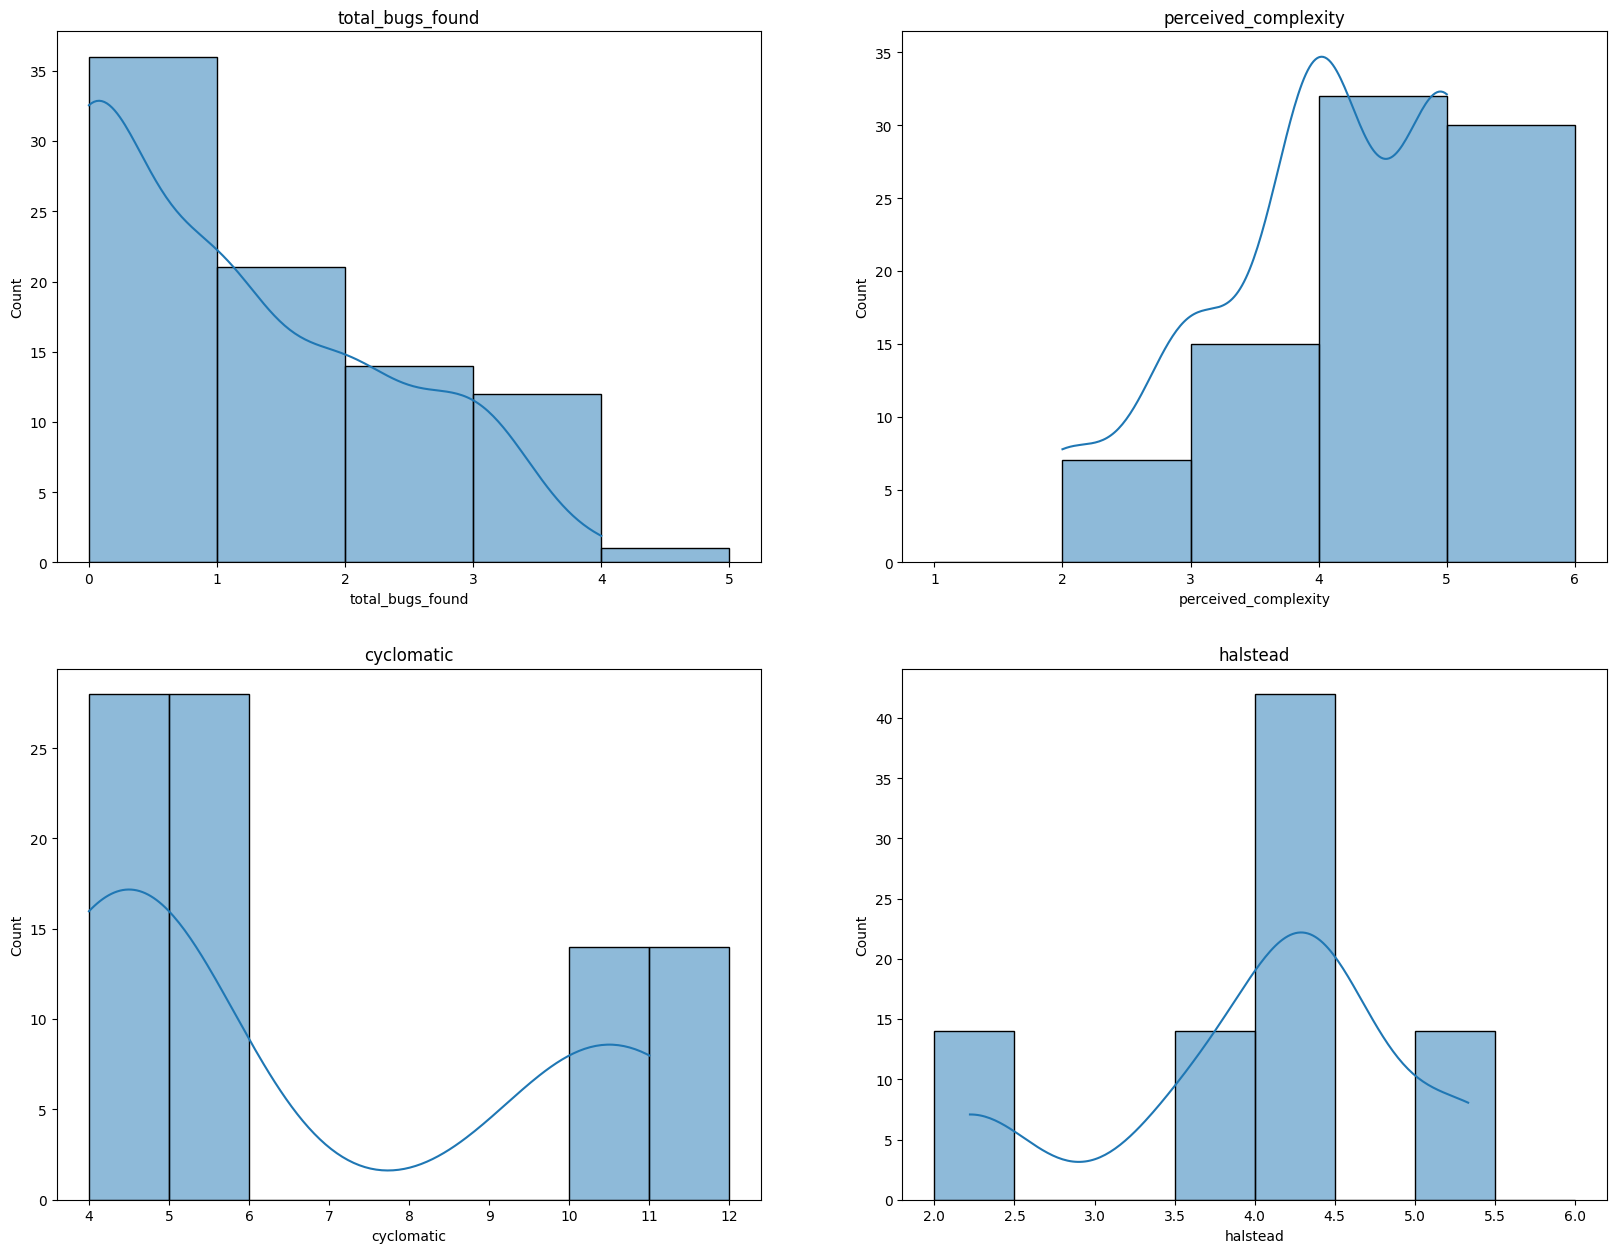

In [24]:
fig = plt.figure(figsize=(20,40)) # 9 plots in 1 column => 9 rows
i=1

for col in ['total_bugs_found']:
    plt.subplot(5,2,i)
    sns.histplot(x=taskData[col], binrange=(0,5), kde=True, bins=5)
    plt.title(col)
    i=i+1

for col in ['perceived_complexity']:
    plt.subplot(5,2,i)
    sns.histplot(x=taskData[col], binrange=(1,6), kde=True, bins=5)
    plt.title(col)
    i=i+1

for col in ['cyclomatic']:
    plt.subplot(5,2,i)
    sns.histplot(x=taskData[col], kde=True, bins=8, binrange=(4,12))
    plt.title(col)
    i=i+1

for col in ['halstead']:
    plt.subplot(5,2,i)
    sns.histplot(x=taskData[col], kde=True, bins=8, binrange=(2,6))
    plt.title(col)
    i=i+1

This once again confirms that participants found the tasks extremely challenging, with low total_bugs_found and high perceived complexity. Furthermore, the discrepency between perceived difficulty and theoretical complexity is highlighted by the differences in distributions between the perceived_complexity histogram on one side, and the cyclomatic/halstead histograms on the other.

The good news is that we succeeded in making tasks that are not *so* easy that everyone finds all bugs. However, the large number of tasks where no bugs at all were found shows that maybe they could heve been a bit easier, *or* that our candidates should have been given more time per task ideally

Finally, we can visually confirm one of the relationships we are perhaps most interested in:

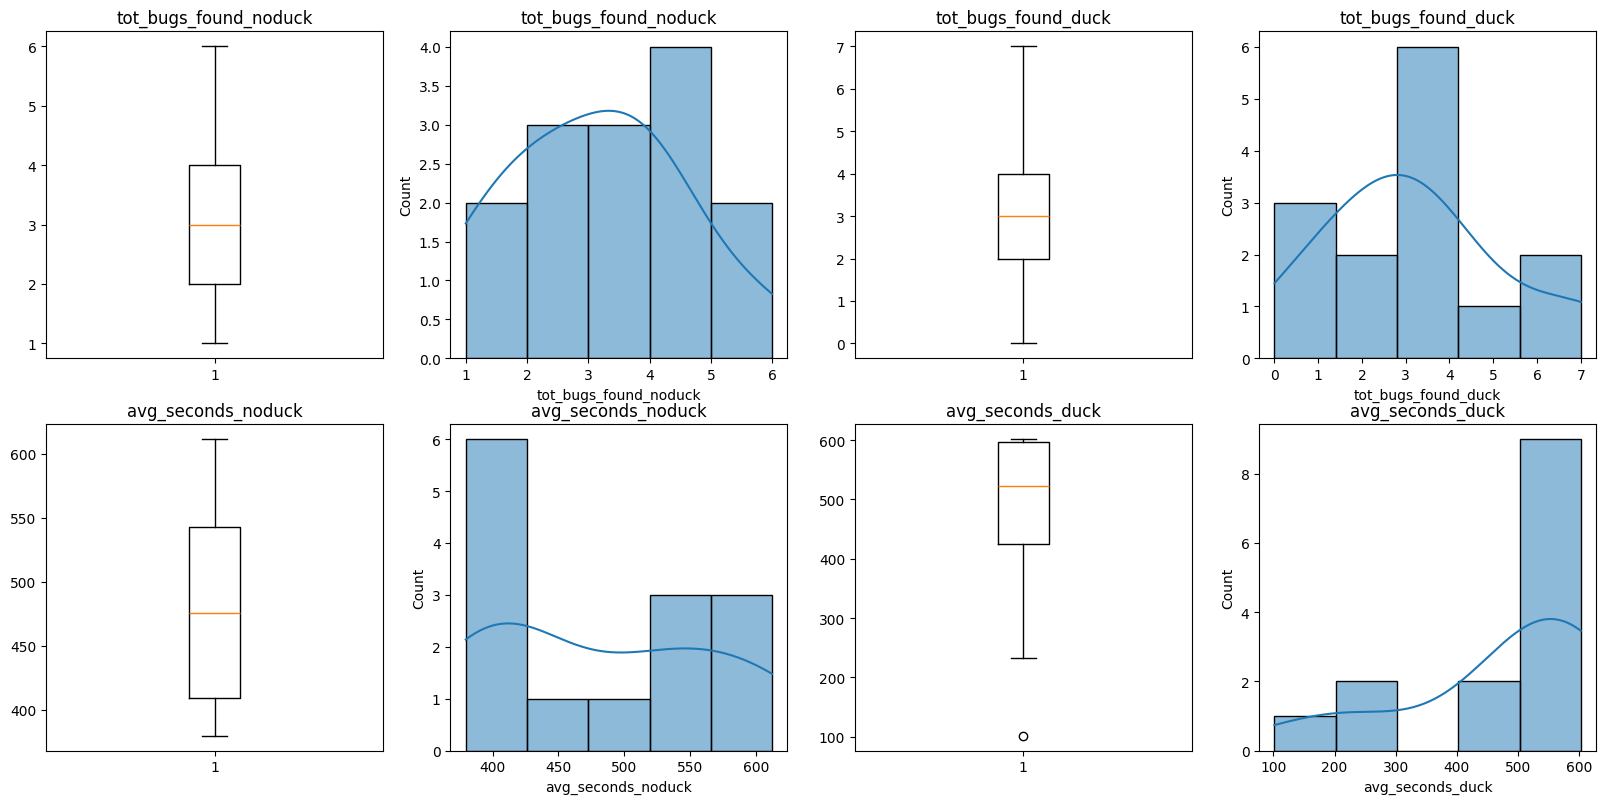

In [25]:
formData['tot_seconds'] = formData['tot_time'].dt.total_seconds()
formData['avg_seconds'] = formData['avg_time'].dt.total_seconds()
formData['tot_seconds_noduck'] = formData['tot_time_noduck'].dt.total_seconds()
formData['tot_seconds_duck'] = formData['tot_time_duck'].dt.total_seconds()
formData['avg_seconds_noduck'] = formData['avg_time_noduck'].dt.total_seconds()
formData['avg_seconds_duck'] = formData['avg_time_duck'].dt.total_seconds()

numerical_column_names = ['tot_bugs_found_noduck', 'tot_bugs_found_duck', 'avg_seconds_noduck', 'avg_seconds_duck']
fig = plt.figure(figsize=(20,45))  # size of one single plot-figure
i = 0

for col in numerical_column_names:
    i=i+1                   # increasing the number of the figure so that they find to the right place
    plt.subplot(9, 4, i)    # reserving the i-th place in the 9 times 4 subplot
    plt.boxplot(formData[col])  # creating the boxplot which is added to subplot
    plt.title(col)          # setting the title of this plot in the center above the figure (= default)
    i=i+1                   # increasing the number for the next figure
    plt.subplot(9, 4, i)    # telling the subplot where to add the next figure
    sns.histplot(x = formData[col], kde = True) #create a histogram with a kde as figure
    plt.title(col)          # setting title of the histogram

fig.savefig('Boxplot&Histogram.jpg') #saving the figure in a file

As we can see, there is unfortunately almost no difference in total bugs found when comparing rubber duck debugging to silent debugging.
However, there is a slight difference in time taken per task between duck and no_duck. However, it is unlikely that this is significant, as we will see later.

## Bivariate data analysis

### Heatmap

A quick way to get an overview of potentially interesting relationships between variables is by using heatmaps.

In [26]:
plt.figure(figsize=(40,20))
sns.heatmap(formData.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

ValueError: could not convert string to float: 'B'

<Figure size 4000x2000 with 0 Axes>

In [ ]:
taskData['task_time'] = taskData['duration'].dt.total_seconds()
plt.figure(figsize=(20,10))
sns.heatmap(taskData.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

ValueError: could not convert string to float: 'Confused Decoder'

<Figure size 2000x1000 with 0 Axes>

Let's do the same thing with one large data frame that holds all of our data (but drops some columns that are not interesting to look at for correlations, such as IDs).

In [ ]:
df1 = pd.merge(formData, taskData, left_on='task_1', right_on='id')
df2 = pd.merge(formData, taskData, left_on='task_2', right_on='id')
df3 = pd.merge(formData, taskData, left_on='task_3', right_on='id')
df4 = pd.merge(formData, taskData, left_on='task_1_duck', right_on='id')
df5 = pd.merge(formData, taskData, left_on='task_2_duck', right_on='id')
df6 = pd.merge(formData, taskData, left_on='task_3_duck', right_on='id')
data = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

data.drop('task_1', axis=1, inplace=True)
data.drop('task_2', axis=1, inplace=True)
data.drop('task_3', axis=1, inplace=True)
data.drop('task_1_duck', axis=1, inplace=True)
data.drop('task_2_duck', axis=1, inplace=True)
data.drop('task_3_duck', axis=1, inplace=True)
data.drop('survey_q3', axis=1, inplace=True)
data.drop('tot_time', axis=1, inplace=True)
data.drop('avg_time', axis=1, inplace=True)
data.drop('tot_time_noduck', axis=1, inplace=True)
data.drop('avg_time_noduck', axis=1, inplace=True)
data.drop('tot_time_duck', axis=1, inplace=True)
data.drop('avg_time_duck', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)
data.drop('duration', axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
threshold = 0.3
mask = np.tril(np.abs(data.corr()) < threshold)

plt.figure(figsize=(40,20))
sns.heatmap(data.corr(), annot=True, mask=mask, fmt='.2g', linewidths=.5, linecolor='grey', vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

ValueError: could not convert string to float: 'B'

While it is important to remember that this heatmap only shows bivariate correlations, we can learn several things from it:



*   Unfortunately, it seems that the solved_with_duck boolean does not correlate to any other variables.
*   The amount of time spent debugging, however, has many correlations with the questions about participants' perception of rubber duck debugging as well as their personality based on the big five inventory.
*   The big five inventory also correlates rather frequently with people's perceptions of rubber duck debugging.
*   The amount of bugs found similarly correlates with the big five inventory and the perception questions.
*   Participants who found more bugs rated the tasks as less difficult.
*   The total amount of bugs found *with* rubber duck has a slightly higher influence than the total amount of bugs found *without*, suggesting that there might be a tiny effect there after all.



## Scatterplots

Based on the heatmap of the previous step, let's take a closer look at some of the interesting correlations we saw.

In [ ]:
sns.set_style('white')
sns.pairplot(data.loc[:,['task_time', 'total_bugs_found', 'perceived_complexity', 'familiarity', 'gender']]
             , hue='gender',diag_kind='hist', palette="icefire")

KeyError: "['task_time'] not in index"

There is unfortunately not much to be seen here due to a lack of data points to get highly populated scatterplots. Knowing that 1 == male and 0 == female, we can see that in our population, women seem to rate code as less complex and more familiar. However, this seems a rather weak observation.

In [ ]:
# sns.set_style('white')
# sns.pairplot(data.loc[:,['perception_q1', 'perception_q2', 'perception_q3', 'perception_q4', 'perception_q5', 'perception_q6', 'perception_q7',
#                          'big_five_q1', 'big_five_q2', 'big_five_q3', 'big_five_q4', 'big_five_q5', 'big_five_q6', 'big_five_q7', 'big_five_q8', 'big_five_q9', 'big_five_q10',
#                          'tot_bugs_found', 'gender', 'coding_proficiency']]
#              , hue='gender',diag_kind='hist', palette="icefire")

Due to some interesting correlations in the heatmap, the above code generates scatterplots between the perception questions, the big five inventory, and some other variables. But, due to lack of data points, there is not much to be seen and the code takes a long time to run due to the high number of combinations.

## Stepwise linear regression modelling

We have now generally explored the data and seen that the bivariate correlations in our data are, at best, weak. However, let's take a look at what happens when we take more than one variable into account in a stepwise linear regression.

In [28]:
def task_set_to_letter2(x):
  if "A" in x: return 1
  elif "B" in x: return 2
  else: return x
for rowIndex in range(len(data)):
  data.group[rowIndex] = task_set_to_letter2(data.group[rowIndex])

NameError: name 'data' is not defined

In [27]:

data['group'] = data['group'].astype(int)
data['gender'] = data['gender'].astype(int)
data['b1_found'] = data['b1_found'].astype(int)
data['b2_found'] = data['b2_found'].astype(int)
data['b3_found'] = data['b3_found'].astype(int)
data['b4_found'] = data['b4_found'].astype(int)
data['solved_with_duck'] = data['solved_with_duck'].astype(int)

data.drop('task_name', axis=1, inplace=True)
print(data.dtypes)

NameError: name 'data' is not defined

In [ ]:
data['talking'] = data['talking'].fillna(6.0 - data['silence'])
data['silence'] = data['silence'].fillna(6.0 - data['talking'])

pd.set_option('display.max_columns', 70)

In [ ]:
# Assume df is your pandas DataFrame with variables (including dependent variable) you want to consider
# Replace 'dependent_variable' with the actual name of your dependent variable
dependent_variable = 'gender'

# Separate the dependent variable and independent variables
y = data[dependent_variable]
X = data.drop(dependent_variable, axis=1)  # Assuming the dependent variable is a column in the DataFrame

# Perform backward stepwise regression
def backward_elimination(X, y):
    cols = list(X.columns)
    pmax = 1
    while len(cols) > 0:
        p = []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y, X_1).fit()
        p = pd.Series(model.pvalues.values[1:], index=cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if pmax > 0.05:
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols

    # Calculate R-squared value
    X_selected = X[selected_features_BE]
    X_selected = sm.add_constant(X_selected)
    model_selected = sm.OLS(y, X_selected).fit()
    r_squared = model_selected.rsquared

    return selected_features_BE, r_squared

selected_features, r_squared = backward_elimination(X, y)

# Display the selected features and R-squared value
print("Selected features:", selected_features)
print("R-squared:", r_squared)

NameError: name 'data' is not defined

In [ ]:
# Forward stepwise linear regression function
def forward_stepwise_regression(data, dependent_variable):
    selected_features = []
    remaining_features = list(data.columns[data.columns != dependent_variable])
    y = data[dependent_variable]

    while remaining_features:
        best_feature = None
        best_model = None
        best_p_value = float('inf')

        for feature in remaining_features:
            model_features = selected_features + [feature]
            X = data[model_features]
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            max_p_value = model.pvalues.max()

            if max_p_value < best_p_value:
                best_feature = feature
                best_model = model
                best_p_value = max_p_value

        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)

    return selected_features, best_model

# Choose your dependent variable
dependent_variable = 'dependent_variable'

# Perform forward stepwise regression
selected_features, model = forward_stepwise_regression(data, 'perceived_complexity')

# Print selected features and regression summary
print("\nSelected features:", selected_features)
print("\nRegression Summary:")
print(model.summary())


Selected features: ['total_bugs_found', 'gender', 'big_five_q10', 'familiarity', 'big_five_q7', 'halstead', 'tot_bugs_found_duck', 'student_id', 'perception_q3', 'big_five_q4', 'b2_found', 'survey_q1', 'group', 'tot_bugs_found_noduck', 'tot_bugs_found', 'perception_q6', 'cyclomatic', 'total_bugs', 'b4_found', 'perception_q5', 'silence', 'talking', 'halbugs', 'solved_with_duck', 'avg_seconds_duck', 'python_proficiency', 'perception_q7', 'coding_proficiency', 'perception_q1', 'tot_seconds', 'avg_seconds', 'avg_seconds_noduck', 'perception_q4', 'perception_q2', 'big_five_q2', 'survey_q2', 'big_five_q9', 'big_five_q6', 'big_five_q8', 'tot_seconds_duck', 'big_five_q5', 'big_five_q3', 'big_five_q1', 'tot_seconds_noduck', 'b1_found', 'b3_found']

Regression Summary:
                             OLS Regression Results                             
Dep. Variable:     perceived_complexity   R-squared:                       0.673
Model:                              OLS   Adj. R-squared:          

# PART 5: ANSWERING RESEARCH QUESTIONS

## RQ 1: Does rubber duck debugging measurably improve the debugging performance?

## RQ2: Does personality type influence the effect of rubber duck debugging?


1) Calculate personality scores for each dimension of Big 5:

- Extraversion: 1R, 6
- Agreeableness: 2, 7R
- Conscientiousness: 3R, 8
- Neuroticism: 4R, 9;
- Openness: 5R; 10

To be reversed: 1, 3, 4, 5, 7

    1.1 reverse the likert values
    1.1 calculate average per dimensions

In [29]:
reverse_mapping = {
    1: 5,
    2: 4,
    3: 3,
    4: 2,
    5: 1
}

dimension_question_mapping = {
    'extraversion': [1, 6],
    'agreeableness': [2, 7],
    'conscientiousness': [3, 8],
    'neuroticism': [4, 9],
    'openness': [5, 10]
}
    
dimensions = list(dimension_question_mapping.keys())
reversed_questions = [1, 3, 4, 5, 7]
all_big_five_questions = [f'big_five_q{i}' for i in range(1, 11)]
                          
# print answers before reverse mapping
print(formData.loc[formData['student_id'] == 1, all_big_five_questions])

for q_id in reversed_questions:
    formData[f'big_five_q{q_id}'] = formData[f'big_five_q{q_id}'].map(reverse_mapping) # apply reverse mapping

# print answers after reverse mapping
print(formData.loc[formData['student_id'] == 1, all_big_five_questions])

# save the average of the two questions per personality dimension as a new column
for dim, q in  dimension_question_mapping.items():
    formData[dim] = formData[[f'big_five_q{q[0]}', f'big_five_q{q[1]}']].mean(axis=1)


    big_five_q1  big_five_q2  big_five_q3  big_five_q4  big_five_q5  \
11            2            5            5            2            1   

    big_five_q6  big_five_q7  big_five_q8  big_five_q9  big_five_q10  
11            4            2            5            4             5  
    big_five_q1  big_five_q2  big_five_q3  big_five_q4  big_five_q5  \
11            4            5            1            4            5   

    big_five_q6  big_five_q7  big_five_q8  big_five_q9  big_five_q10  
11            4            4            5            4             5  


Show personality distribution in entire dataset

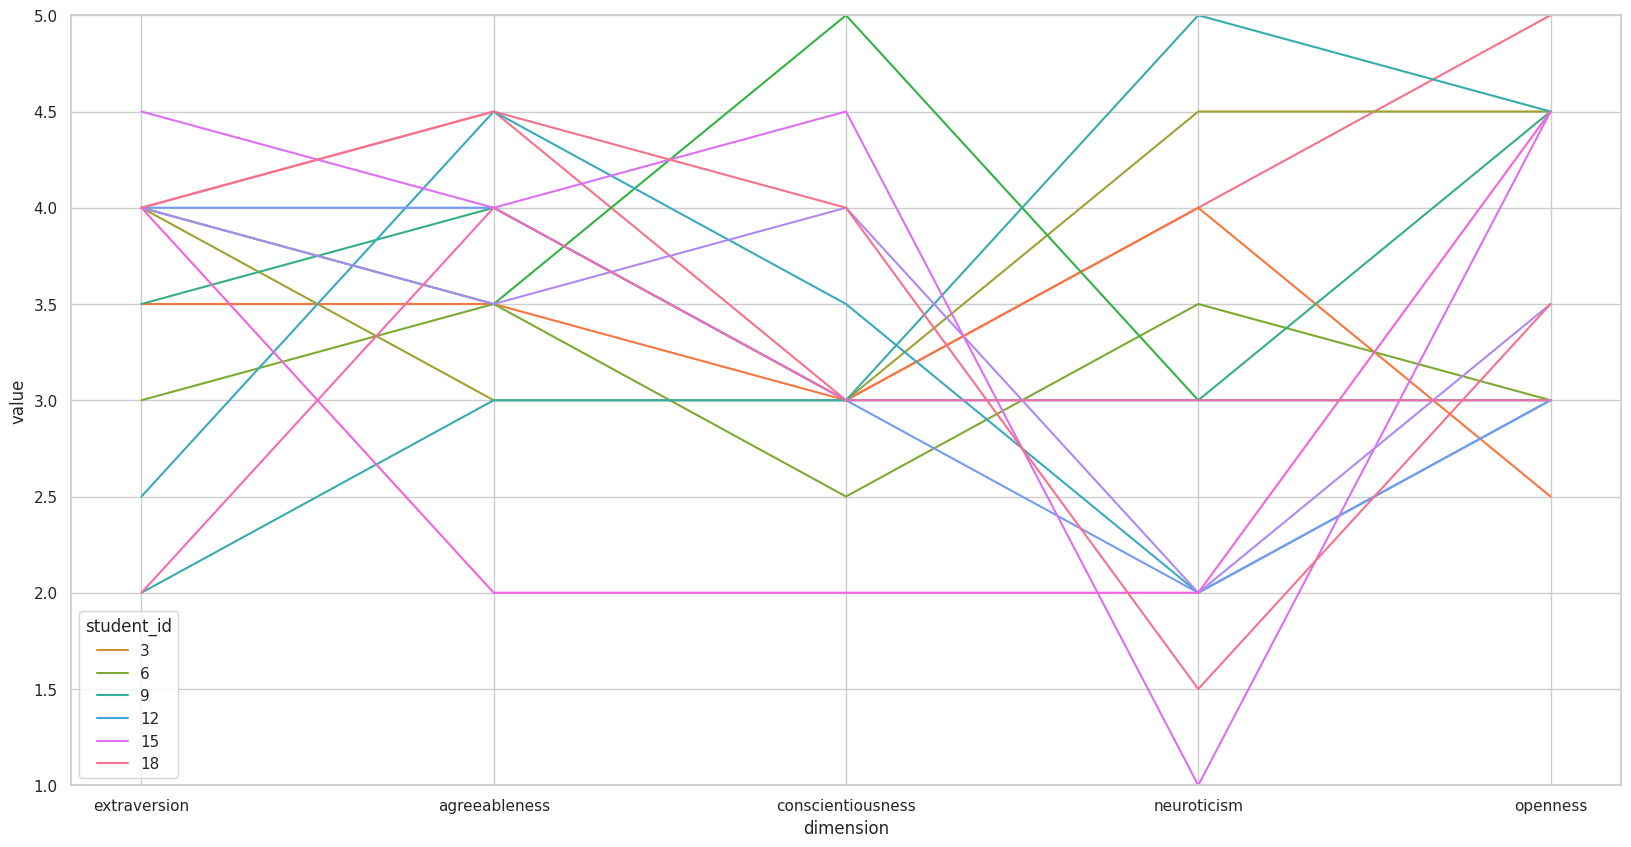

In [40]:
personality_data = formData[[ 'student_id'] + dimensions]

melted_data = pd.melt(personality_data, id_vars=['student_id'], var_name='dimension', value_name='value')
plt.figure(figsize=(20, 10))

# Create parallel coordinates plot
sns.set(style="whitegrid")
sns.lineplot(x='dimension', y='value', hue='student_id', data=melted_data, palette="husl")
plt.ylim(1, 5)
plt.show()

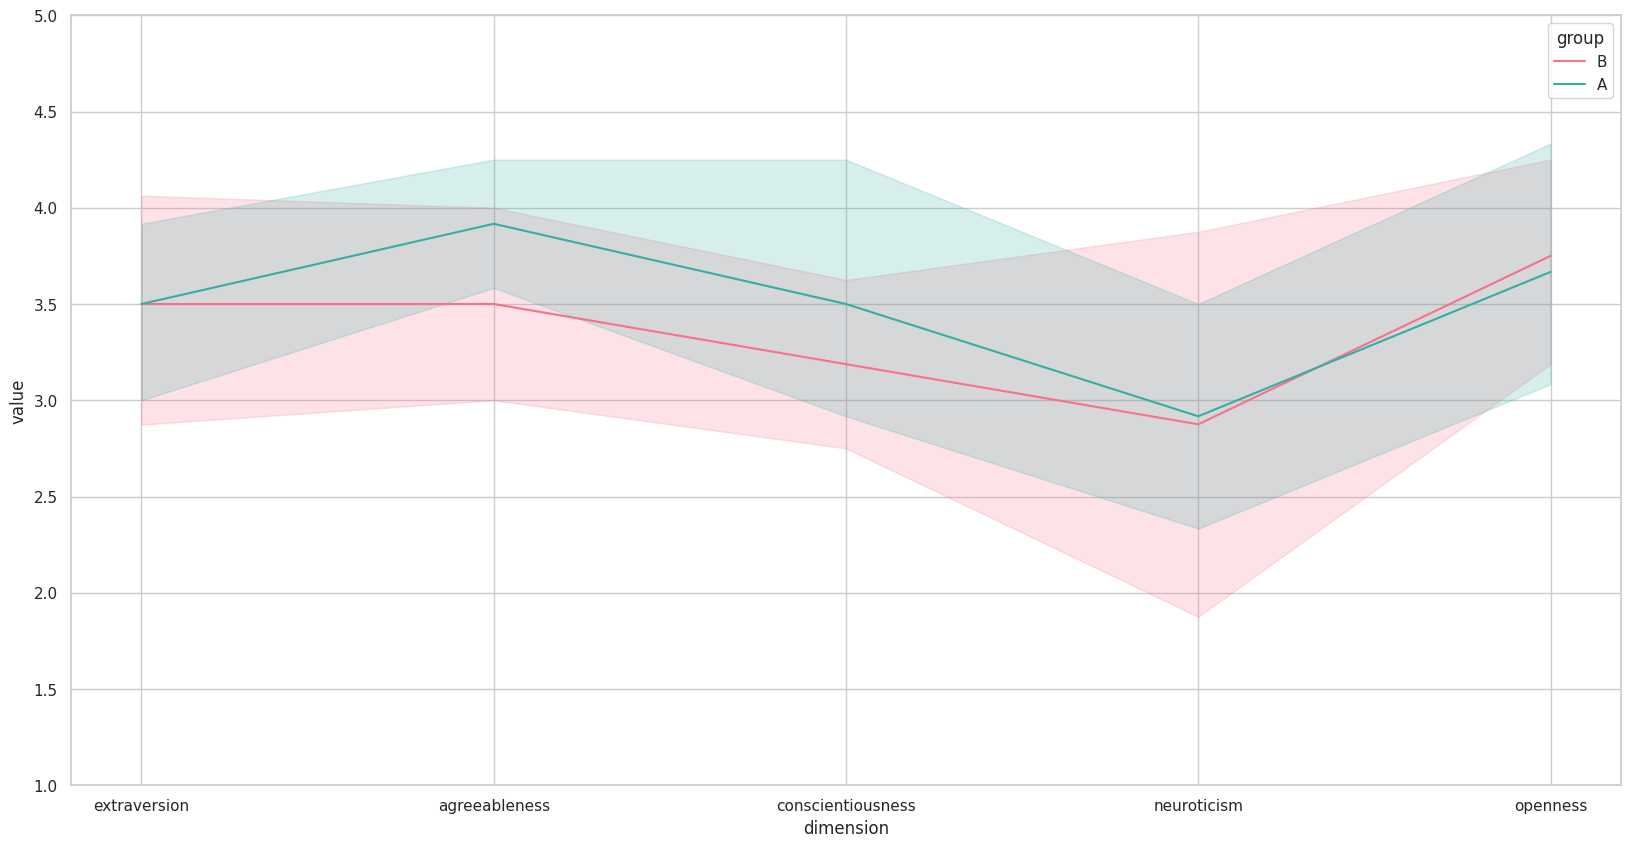

In [41]:
personality_data = formData[[ 'group'] + dimensions]

melted_data = pd.melt(personality_data, id_vars=['group'], var_name='dimension', value_name='value')
plt.figure(figsize=(20, 10))

# Create parallel coordinates plot
sns.set(style="whitegrid")
sns.lineplot(x='dimension', y='value', hue='group', data=melted_data, palette="husl")
plt.ylim(1, 5)
plt.show()

Plot a series of scatterplots juxtaposing personality traits with
- how comofortable participants were with rubber duck debugging
- how many bugs have been found with the rubber duck
- the difference in total bugs found in with/wihtout rubber duck condition

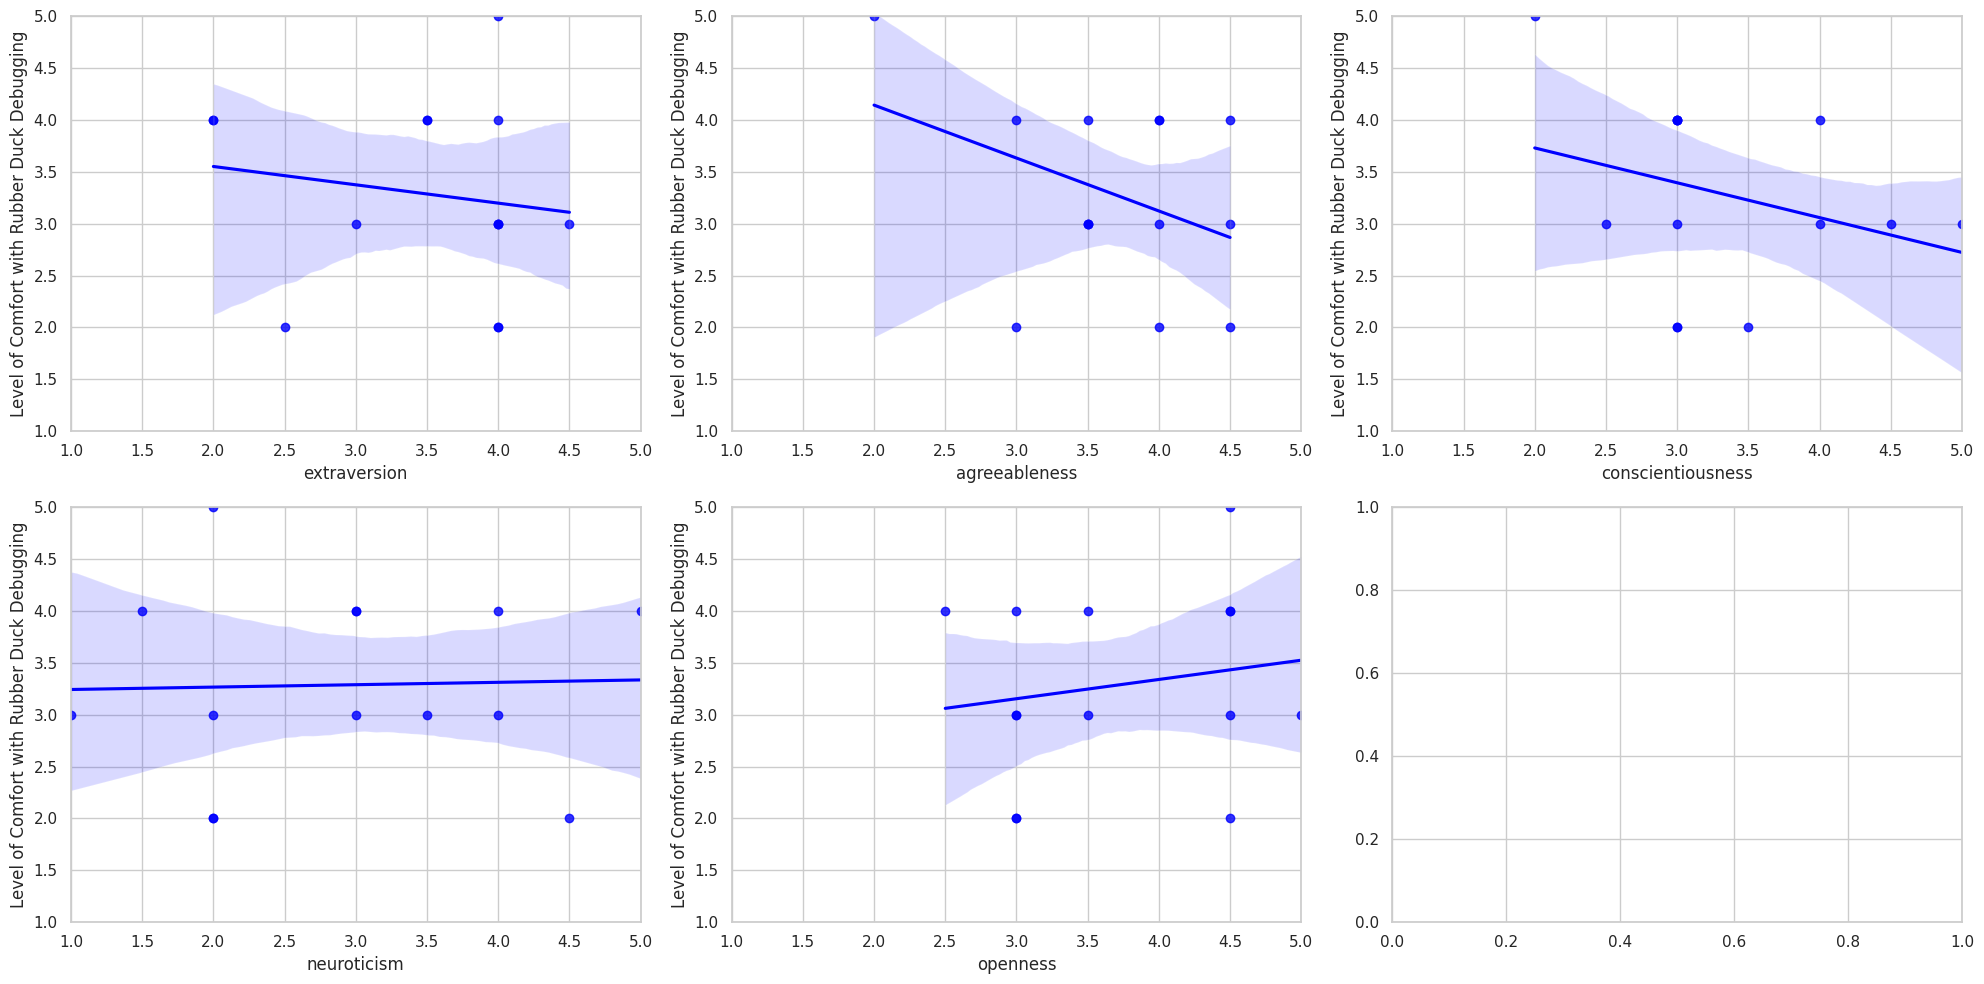

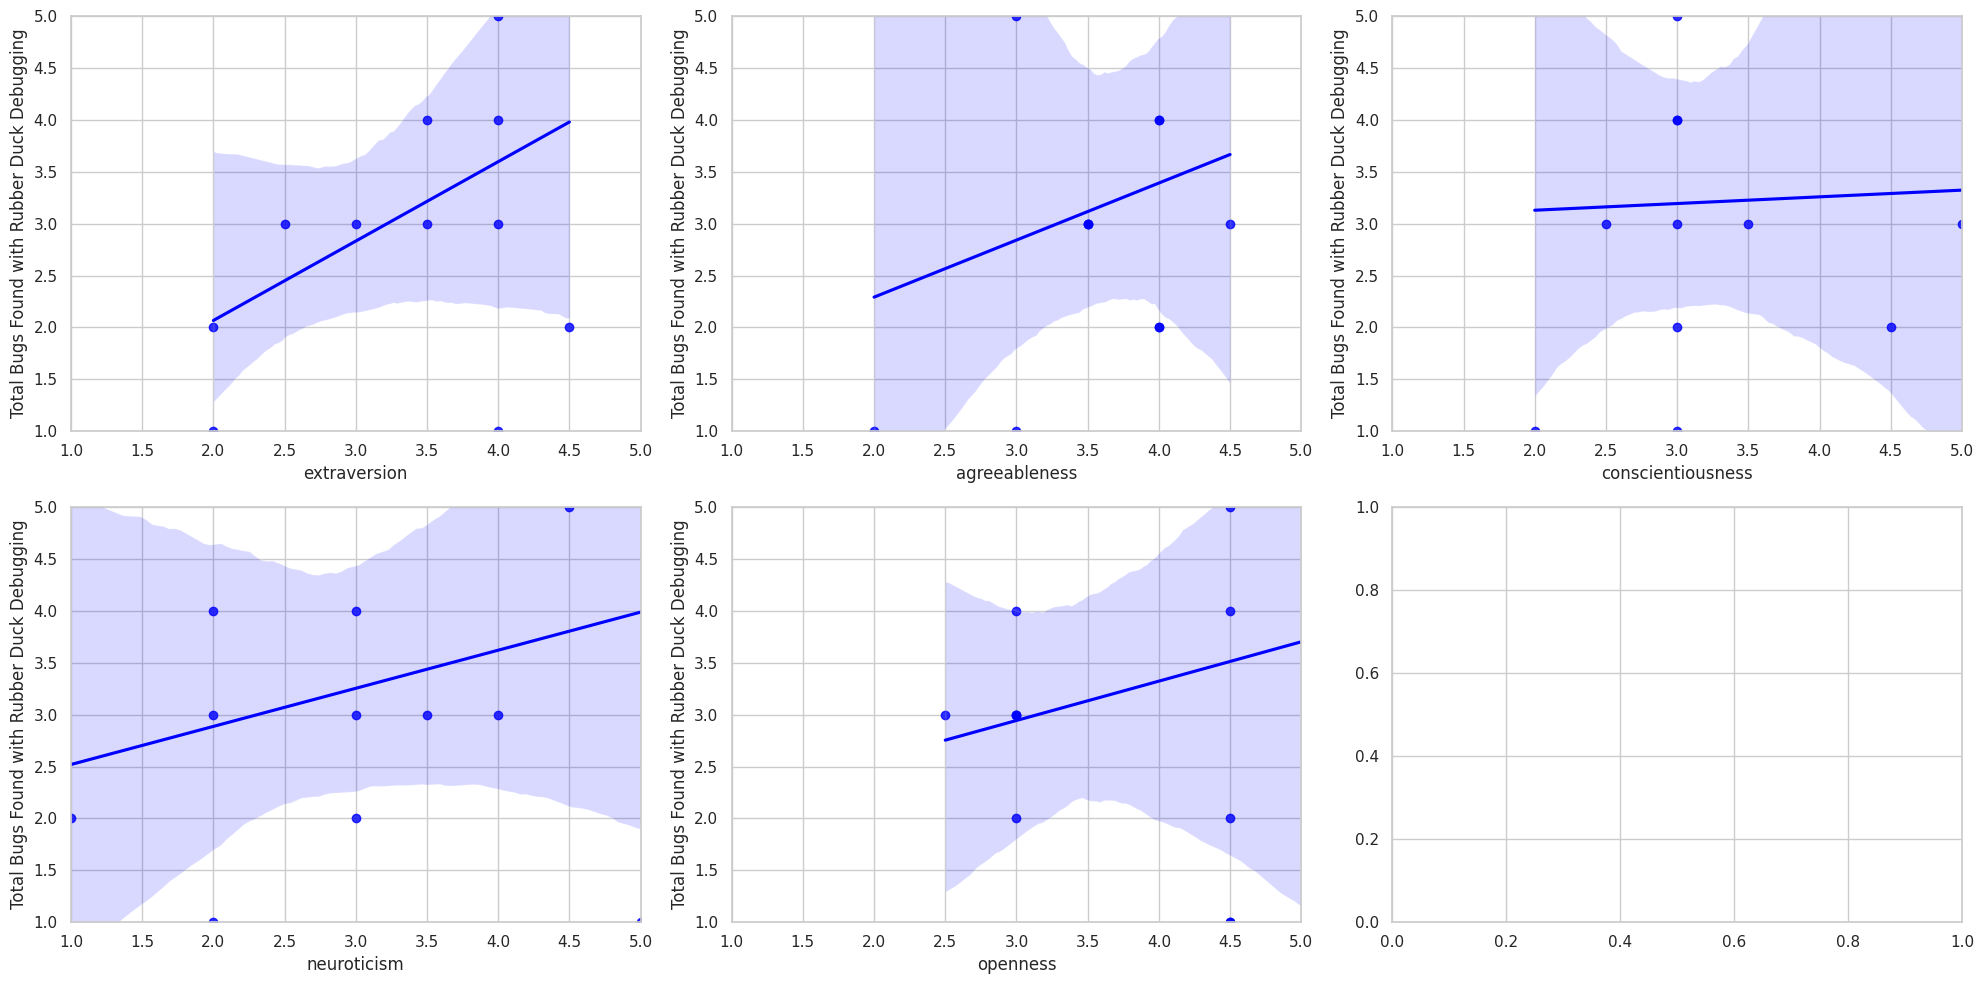

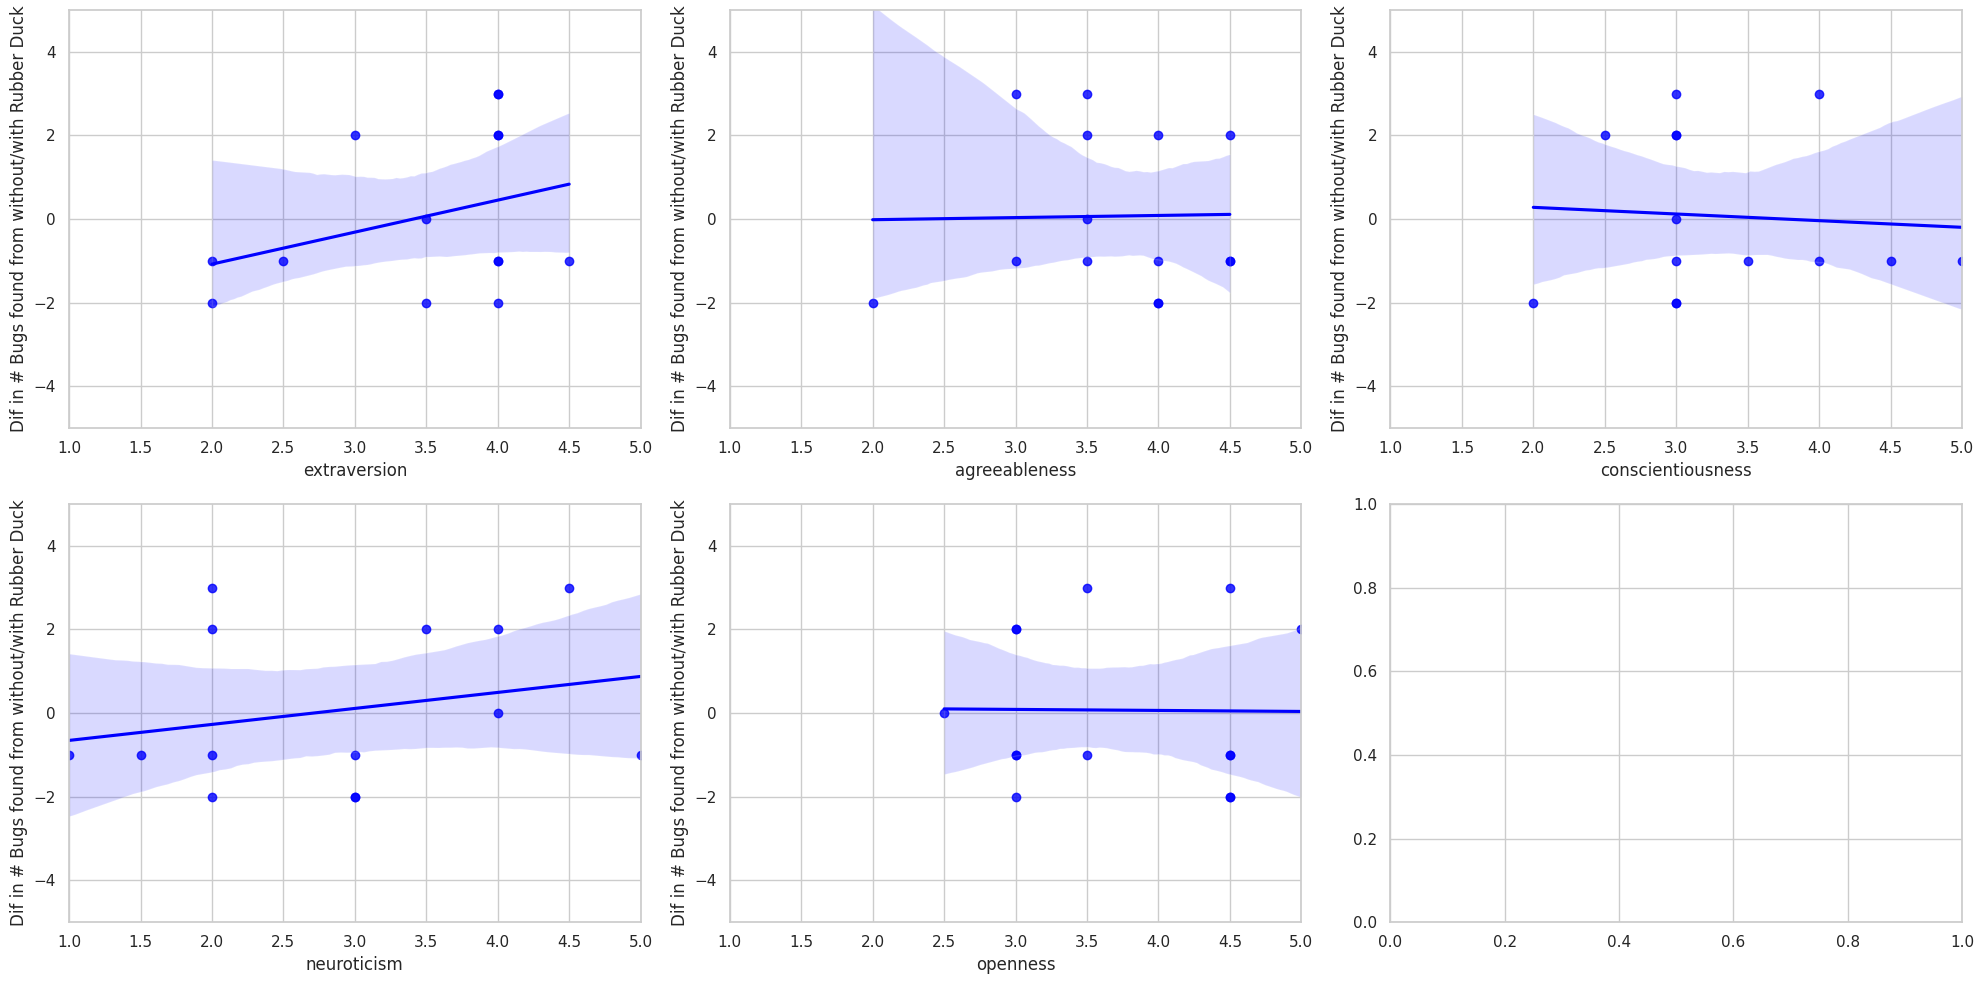

In [43]:
comfortable = 'survey_q2' # I was comfortable using rubber duck debugging

def plot_personlity_vs(y: str, y_label: str, x_limits: tuple = (1, 5), y_limits: tuple = (1, 5)):
    num_rows = 2 
    num_cols = (len(dimensions) + num_rows - 1) // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axes = axes.flatten()
    for i, dim in enumerate(dimensions):
        sns.regplot(x=dim, y=y, data=formData, color='blue', ax=axes[i])
        # Set labels
        axes[i].set_xlabel(dim)
        axes[i].set_ylabel(y_label)
        # set x and y limits
        axes[i].set_xlim(x_limits)
        axes[i].set_ylim(y_limits)
    plt.tight_layout() 
    # Show the plot
    plt.show()

plot_personlity_vs(comfortable, 'Level of Comfort with Rubber Duck Debugging')
plot_personlity_vs('tot_bugs_found_duck', 'Total Bugs Found with Rubber Duck Debugging')

# add new column with difference between total bugs found with and without rubber duck debugging
formData['bugs_found_difference'] = formData['tot_bugs_found_duck'] - formData['tot_bugs_found_noduck']
plot_personlity_vs('bugs_found_difference', 'Dif in # Bugs found from without/with Rubber Duck', y_limits=(-5, 5))

Eyeballing the graph above, there seems to be no strong link between personality dimensions and how comfortable they are with rubber duck debuggin. 
Also there is no link between the amount of bugs found with the rubber duck.

I also hypothesized that maybe rubber duck debugging has made more of a difference/helped extroverted people more, so I tried to link the absolute difference in number of bugs found between the with and without duck conditions. Even though increasing line seems kinda promising in the extroversion graph. 

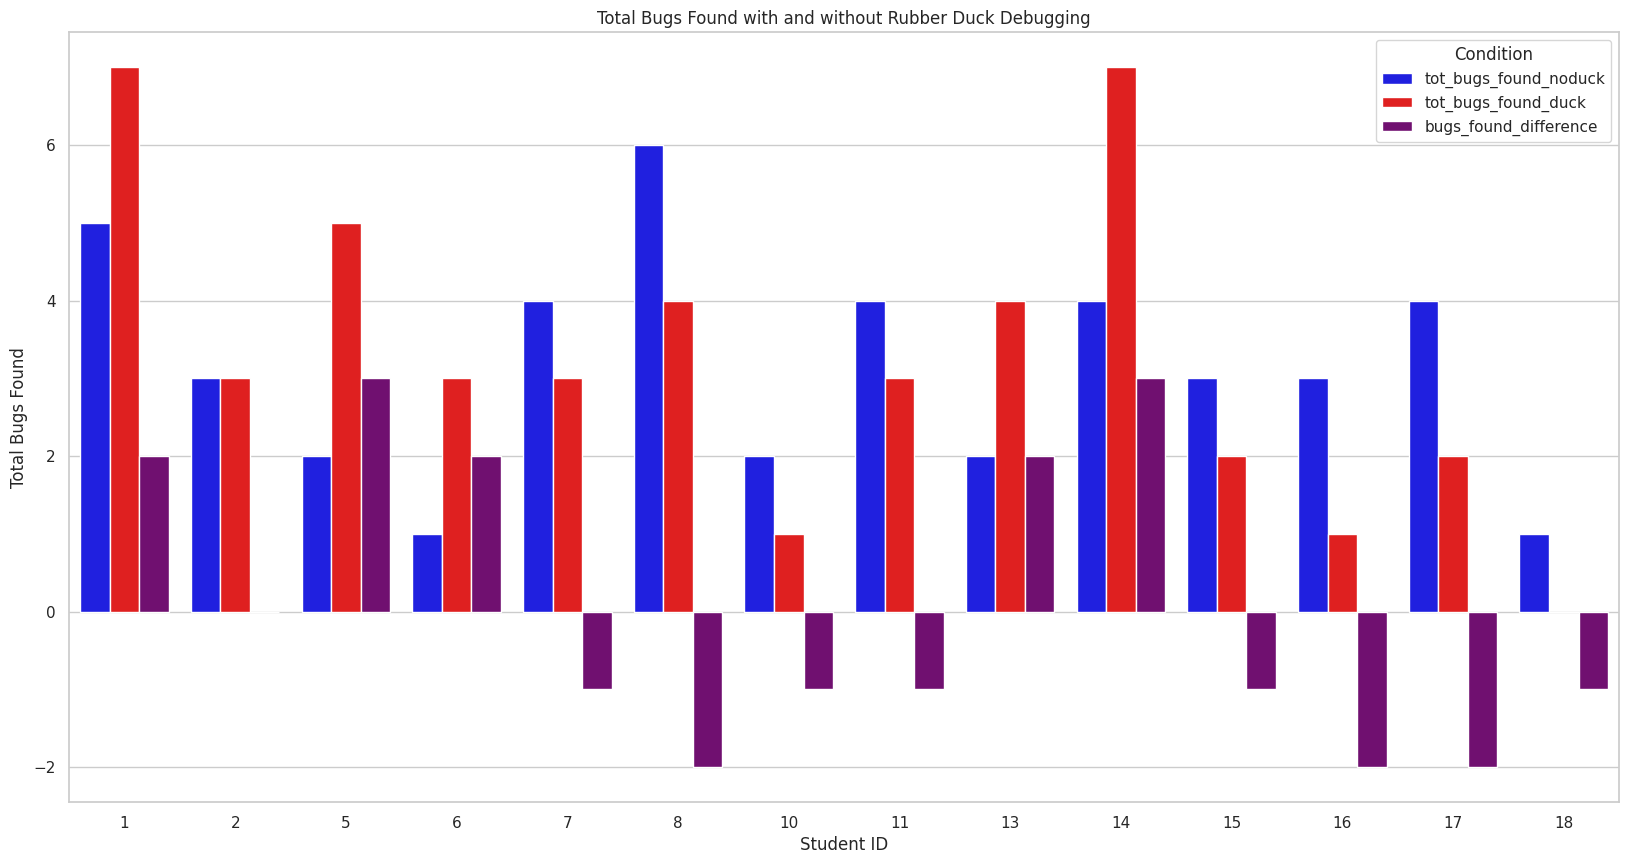

In [44]:
plt.figure(figsize=(20, 10))

melted_data = pd.melt(formData, id_vars=['student_id'], value_vars=['tot_bugs_found_noduck', 'tot_bugs_found_duck', 'bugs_found_difference'],
                      var_name='Condition', value_name='Total Bugs Found')

sns.barplot(x='student_id', y='Total Bugs Found', hue='Condition', data=melted_data, palette=['blue', 'red', 'purple'])

plt.legend(title='Condition')
plt.xlabel('Student ID')
plt.ylabel('Total Bugs Found')
plt.title('Total Bugs Found with and without Rubber Duck Debugging')

plt.show()

Just plotting the number of bugs find with and without rubber duck debugging, I found the whether they found more or less ducks with rubber duck debugging is very different. Like half found more bugs with the duck and half less with the duck.

In [45]:
print(formData.columns)

Index(['student_id', 'group', 'task_1', 'task_2', 'task_3', 'task_1_duck',
       'task_2_duck', 'task_3_duck', 'survey_q1', 'survey_q2', 'survey_q3',
       'perception_q1', 'perception_q2', 'perception_q3', 'perception_q4',
       'perception_q5', 'perception_q6', 'perception_q7', 'big_five_q1',
       'big_five_q2', 'big_five_q3', 'big_five_q4', 'big_five_q5',
       'big_five_q6', 'big_five_q7', 'big_five_q8', 'big_five_q9',
       'big_five_q10', 'tot_time', 'avg_time', 'tot_time_noduck',
       'tot_time_duck', 'avg_time_noduck', 'avg_time_duck', 'tot_bugs_found',
       'tot_bugs_found_noduck', 'tot_bugs_found_duck', 'python_proficiency',
       'coding_proficiency', 'gender', 'tot_seconds', 'avg_seconds',
       'tot_seconds_noduck', 'tot_seconds_duck', 'avg_seconds_noduck',
       'avg_seconds_duck', 'extraversion', 'agreeableness',
       'conscientiousness', 'neuroticism', 'openness',
       'bugs_found_difference'],
      dtype='object')


In [46]:
formData = sm.add_constant(formData)

predictors = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness',
              'coding_proficiency', 'python_proficiency']

linear_model = sm.OLS(formData['bugs_found_difference'], formData[predictors])
linear_result = linear_model.fit()

print(linear_result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     bugs_found_difference   R-squared (uncentered):                   0.364
Model:                               OLS   Adj. R-squared (uncentered):             -0.273
Method:                    Least Squares   F-statistic:                             0.5714
Date:                   Fri, 08 Dec 2023   Prob (F-statistic):                       0.761
Time:                           12:56:13   Log-Likelihood:                         -25.179
No. Observations:                     14   AIC:                                      64.36
Df Residuals:                          7   BIC:                                      68.83
Df Model:                              7                                                  
Covariance Type:               nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---

/home/vera/Documents/Uni/Master/HS23/HS23_Human_Aspect_of_Software_Engineering/Project/duck-exp/new_django_venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We calculated the difference between the number bugs found in the condition 'debugging without duck' and 'debugging with rubber duck'. We fitted a linear regression model on the five personality dimension and general coding experience and Python coding experience in particular to predict the difference in number of bugs between the two condition. However, the resulting model exhibited a limited explanatory capacity, reflected by a modest R² value of 0.364. Our analysis revealed that neither personality traits nor coding proficiency, encompassing both general coding experience and Python-specific skills, could were a statiscally significant predictor of the observed differences in number of bug identification.  

In [47]:
predictors = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness',
              'coding_proficiency', 'python_proficiency']

linear_model = sm.OLS(formData['survey_q2'], formData[predictors])
linear_result = linear_model.fit()

print(linear_result.summary())

                                 OLS Regression Results                                
Dep. Variable:              survey_q2   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.871
Method:                 Least Squares   F-statistic:                              14.48
Date:                Fri, 08 Dec 2023   Prob (F-statistic):                     0.00112
Time:                        12:56:22   Log-Likelihood:                         -17.829
No. Observations:                  14   AIC:                                      49.66
Df Residuals:                       7   BIC:                                      54.13
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/home/vera/Documents/Uni/Master/HS23/HS23_Human_Aspect_of_Software_Engineering/Project/duck-exp/new_django_venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We also fitted a linear model predicting the level of comfort with rubber duck debugging. Participants' comfort with rubber duck debugging does not appear to be significantly influenced by their personality traits or coding expertise.

In [48]:
predictors = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness',
              'coding_proficiency', 'python_proficiency']

linear_model = sm.OLS(formData['avg_seconds_duck'], formData[predictors])
linear_result = linear_model.fit()

print(linear_result.summary())

                                 OLS Regression Results                                
Dep. Variable:       avg_seconds_duck   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                              9.421
Date:                Fri, 08 Dec 2023   Prob (F-statistic):                     0.00420
Time:                        12:56:30   Log-Likelihood:                         -90.272
No. Observations:                  14   AIC:                                      194.5
Df Residuals:                       7   BIC:                                      199.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/home/vera/Documents/Uni/Master/HS23/HS23_Human_Aspect_of_Software_Engineering/Project/duck-exp/new_django_venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We also fitted a linear model to predict the average of time spent with rubber duck debugging. None of the considered personality traits or coding expertise significantly influences the average time participants spent per task while rubber duck debugging.

In [51]:
predictors = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness',
              'coding_proficiency', 'python_proficiency']

linear_model = sm.OLS(formData['survey_q1'], formData[predictors])
linear_result = linear_model.fit()

print(linear_result.summary())

                                 OLS Regression Results                                
Dep. Variable:              survey_q1   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              14.59
Date:                Fri, 08 Dec 2023   Prob (F-statistic):                     0.00109
Time:                        12:58:21   Log-Likelihood:                         -13.584
No. Observations:                  14   AIC:                                      41.17
Df Residuals:                       7   BIC:                                      45.64
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/home/vera/Documents/Uni/Master/HS23/HS23_Human_Aspect_of_Software_Engineering/Project/duck-exp/new_django_venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We also fitted a linear model to predict how often people use rubber duck debugging outside of the study. personality type or coding expertise does not significantly predict this. 

## RQ3: Does the perceived effect of rubber duck debugging match the measured effect?